Epoch [1/100], Training Loss: 0.7930
Epoch [1/100], Validation Loss: 0.5289
Epoch [2/100], Training Loss: 0.4361
Epoch [2/100], Validation Loss: 0.4578
Epoch [3/100], Training Loss: 0.2035
Epoch [3/100], Validation Loss: 0.3983
Epoch [4/100], Training Loss: 0.3676
Epoch [4/100], Validation Loss: 0.3482
Epoch [5/100], Training Loss: 0.4302
Epoch [5/100], Validation Loss: 0.4231
Epoch [6/100], Training Loss: 0.4121
Epoch [6/100], Validation Loss: 0.2948
Epoch [7/100], Training Loss: 0.0551
Epoch [7/100], Validation Loss: 0.2701
Epoch [8/100], Training Loss: 0.0540
Epoch [8/100], Validation Loss: 0.2555
Epoch [9/100], Training Loss: 0.4475
Epoch [9/100], Validation Loss: 0.2374
Epoch [10/100], Training Loss: 0.5537
Epoch [10/100], Validation Loss: 0.2312
Epoch [11/100], Training Loss: 0.0643
Epoch [11/100], Validation Loss: 0.2366
Epoch [12/100], Training Loss: 0.3761
Epoch [12/100], Validation Loss: 0.2699
Epoch [13/100], Training Loss: 0.1007
Epoch [13/100], Validation Loss: 0.2508
Epoc

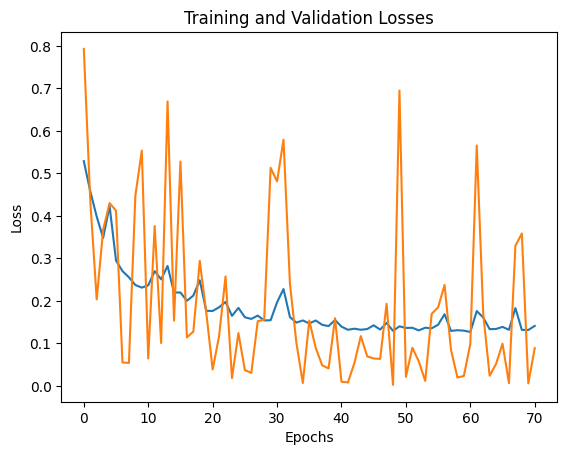

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

start_time = time.time()

torch.manual_seed(170401019)

# Load the datasets
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.15)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Define the model's input and output dimensions
input_dim = 13 # e.g. the input feature dimension is 13
hidden_dim1 = 100 # e.g. the first hidden layer has 100 units
hidden_dim2 = 50 # e.g. the second hidden layer has 50 units
output_dim = 1 # e.g. the output is a single scalar value

# Create an instance of the MLP model
mlp_model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)

# Define the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01)

# Convert the data to PyTorch tensors
x_train = torch.from_numpy(train_df.drop('Cured', axis=1).values).float()
y_train = torch.from_numpy(train_df['Cured'].values).float().unsqueeze(1)
x_val = torch.from_numpy(val_df.drop('Cured', axis=1).values).float()
y_val = torch.from_numpy(val_df['Cured'].values).float().unsqueeze(1)
x_test = torch.from_numpy(train_df.drop('Cured', axis=1).values).float()
y_test = torch.from_numpy(train_df['Cured'].values).float().unsqueeze(1)


Z_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
Q_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)
# Define the batch size
batch_size = 32

# Create PyTorch data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# Train the model
num_epochs = 100
loss_list = []
train_losses = []
val_losses = []

patience = 10
best_val_loss = float('inf')
patience_count = 0

for epoch in range(num_epochs):
    # Training loop
    mlp_model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = mlp_model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_losses.append(loss.item())
    # Print the epoch and training loss
    print("Epoch [{}/{}], Training Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))
    
    # Validation loop
    mlp_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            output = mlp_model(data)
            val_loss += loss_fn(output, target).item() * data.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
     # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_count = 0
    else:
        patience_count += 1
        if patience_count == patience:
            print('Early stopping!')
            break
    
    # Print the epoch and validation loss
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss, train_loss))
    loss_list.append(loss.item())

# Evaluate the model on test set
mlp_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, outputs in test_loader:
        
        # Forward pass and calculate accuracy
        outputs = mlp_model(data)
        predicted = torch.round(outputs)
        total += outputs.size(0)
        correct += (predicted == outputs).sum().item()

    test_acc = correct / total
    print(f"Test accuracy: {test_acc:.4f}")
    
end_time = time.time() 
epoch_time = end_time - start_time

# Tahminleri yap
with torch.no_grad():
    mlp_model.eval()
    y_pred = mlp_model(Z_test)
    y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
    if Q_test.ndim > 1:
        y_true = Q_test.argmax(axis=1)
    else:
        y_true = Q_test

accuracy = accuracy_score(y_true, y_pred_classes)

precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=1)

recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=1)

f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


print("Geçen süre",epoch_time,"seconds")
plt.plot(val_losses)
plt.plot(train_losses)
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()